In [1]:
# import sys
# import gymnasium as gym
# sys.modules["gym"] = gym
import gym
gym.__version__

In [3]:
import gnwrapper

In [4]:
import os
import numpy as np
import torch
print(torch.cuda.is_available())

True


In [5]:
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback

In [6]:
env_id = "MountainCarContinuous-v0"
NUM_CPU = 32  # Number of processes to use

In [7]:
# Parallel environments
train_env = make_vec_env(env_id, n_envs=NUM_CPU)
train_env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [10]:
eval_callback = EvalCallback(train_env, 
                             best_model_save_path="./logs/best_model",
                             log_path="./logs/results", 
                             eval_freq=500,
                             deterministic=True, render=False)
model = PPO("MlpPolicy", 
            train_env,
            verbose=1, 
            seed=0,
            batch_size=512,
            # ent_coef=0.00429,
            learning_rate=7.77e-05,
            n_epochs=10,
            n_steps=8*NUM_CPU,
            gae_lambda=0.9,
            gamma=0.9999,
            # clip_range=0.1,
            max_grad_norm=5,
            # vf_coef=0.19,
            use_sde=True,
            # policy_kwargs=dict(log_std_init=-3.29, ortho_init=False),
            tensorboard_log="./logs/ppo_MountainCar_tensorboard/")

model.learn(total_timesteps=1_000_000, callback=eval_callback, progress_bar=True)
model.save("./logs/ppo_MountainCar")

del model # remove to demonstrate saving and loading

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1,005,280/1,000,000  [ 0:01:10 < 0:00:00 , 15,923 it/s ]
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1,005,280/1,000,000  [ 0:01:10 < 0:00:00 , 15,923 it/s ]

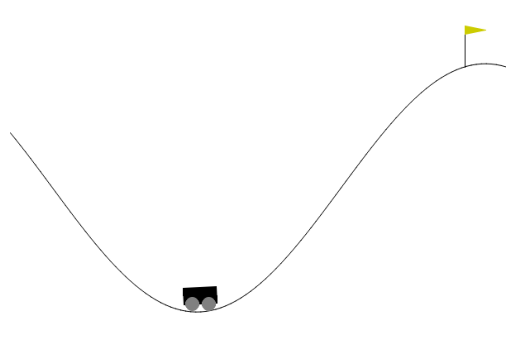

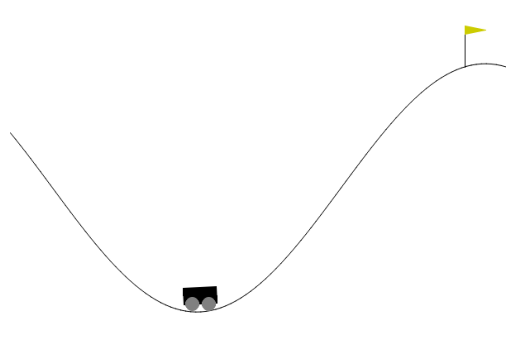

In [9]:
# test_env = gym.make(env_id, render_mode="human")
# test_env = gnwrapper.Animation(test_env)
# test_env = DummyVecEnv([lambda: test_env])

test_env = make_vec_env(env_id,
                        env_kwargs=dict(
                            render_mode="rgb_array"
                        ),
                        wrapper_class=gnwrapper.Animation,
                        n_envs=1)

model = PPO.load("./logs/ppo_MountainCar.zip", print_system_info=True)

obs = test_env.reset()

for _ in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = test_env.step(action)
    test_env.render()
    
    # if dones:
    #     break

test_env.close()
    

In [9]:
test_env = make_vec_env(env_id,
                        env_kwargs=dict(
                            render_mode="human"
                        ),
                        n_envs=1)

model = PPO.load("ppo_MountainCar")

obs = test_env.reset()

for _ in range(100):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = test_env.step(action)
    
    if dones:
        break

test_env.close()
    